# An Entropic Analysis of Quantum Algorithms

## Goal: 
Analyze the entropy and information content for partitions of a quantum register during the steps of quantum algorithms

## Motivation: 

Given that quantum algorithms gain a speedup in their time-complexity as compared with classical computers, we want to understand what fuels this speedup.

## Introduction and definitions:

We define a **qubit** as a two-state system completely described as a vector in Hilbert space $\mathcal{H} = \mathbb{C}^2$. A **quantum register** of $N$ qubits is then described by the tensor product structure $\mathcal{H}^1=\mathbb{C}^2\otimes \mathbb{C}^2\otimes ... = \mathbb{C}^{2N}$. Therefore, at any given point, the state of the quantum register is a single vector living in this Hilbert space $\ket{\psi}\in\mathcal{H}$.


Below are just the Python libraries I imported for this project.

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library.standard_gates import ZGate, TGate, CXGate
from qiskit.visualization import plot_histogram
from qiskit import quantum_info
from itertools import combinations
import sympy as sp
from itertools import chain, repeat
import matplotlib.pyplot as plt 
from tqdm.notebook import trange, tqdm
from sympy.physics.quantum import TensorProduct
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

### Bipartitioning
Since the quantum register is using a tensor product structure, one might ask what the density matrix of a set of $M$ out of the original $N$ qubits looks like, which will help us analyze the entropy of that subsystem. Earlier we introduced the idea of an **entropy vector**. This entropy vector is the list of the entropy for every possible bipartition of the overall Hilbert space. 
We define the **Partial Trace** as this reduced density matrix. If the Hilbert space is bipartitioned as $\mathcal{H} = \mathcal{H}^A\otimes\mathcal{H}^{\bar{A}}$, then one can find the reduced density matrix, or partial trace of $\mathcal{H}^A$ by 'tracing out' $\mathcal{H}^{\bar{A}}$: $\rho^A=\text{Tr}_{\bar{A}}\rho$. Thus our first problem is writing an algorithm to produce all such bipartitions. The algorithm below generates all combinations of a list with a given size, starting at $0$ and ending at $N/2$, adding each combination and its complement to a list to return, containing every way to bipartition the input list. Each bipartition is a list of two elements, sorted according to Python's defsault `sort()` function, which is to avoid double counting and the the list of all bipartitions is sorted again to preserve lexicographic ordering.

In [8]:
#input
def bipartitioning(qubs):
    """
    Generate a list of all bipartitions of a list

    Parameters:
    qubs (list): list to find all bipartitions of
    
    Returns: 
    bipartitions (list): list of all bipartitions where each element has 2 lists, the list of elements in the first piece, and the remining list of its complement
    """

    #Number of elements in the overall system
    N=len(qubs)
    bipartitions = list()

    #Loop over number of elements in the first subsystem from 0 to N/2
    for size_A in range(math.ceil(N/2)+1):
        #Generates a tuple of all combinations that can be made of size_A qubits out of the system
        combs = combinations(qubs,size_A)
        #Loop over every possible combination
        for c in combs:
            combination = list(c)
            combination.sort()
            #Determine the complement of the combination that completes the system
            complement = qubs[:]
            for bit in combination:
                complement.remove(bit)
            complement.sort()
            #Each bipartition has 2 subsystems, the list of pieces in the first subsystem, and its complement
            new_bipartition = [combination,complement]
            new_bipartition.sort()
            #Do not store duplicate bipartitions
            if new_bipartition not in bipartitions:
                bipartitions.append(new_bipartition)
    bipartitions.sort()
    return bipartitions

### Tripartitioning

While we do not need tripartitioning to compute the entropy vector, it is useful to make checks of strong subadditivity and monogamy of mutual information. Here the algorithm finds all bipartitions using the above function, and finds all bipartitions of each piece in that bipartition, producing a list of tripartitions of the original list, again with each partition sorted as well as the overall list.

In [9]:
def tripartitioning(qubs):
    """
    Generate a list of all tripartitions of a list

    Parameters:
    qubs (list): list to find all tripartitions of
    
    Returns: 
    tripartitions (list): list of all bipartitions where each element has 2 lists, the list of elements in the first piece, and the remining list of its complement
    """
    tripartitions = list()
    #Bipartition a single piece of each bipartition to form a tripartition
    for bipartition in bipartitioning(qubs):
        for piece in range(2):
            for subpartition in bipartitioning(bipartition[piece]):
                new_tripartition = [subpartition[0],subpartition[1],bipartition[1-piece]]
                new_tripartition.sort()
                if new_tripartition not in tripartitions:
                    tripartitions.append(new_tripartition)
    tripartitions.sort()
    return tripartitions


We now define the **density matrix** $\rho$ as an operator which depends on the state of the system:$$\rho=\ket{\psi}\bra{\psi}$$

Given a density matrix, the **Von Neumann Entropy** is defined as $S=-tr(\rho\ln\rho)$, which is equivalent to the **Shannon entropy** when $\rho$ is written in the basis of its eigenvectors:$-\sum_i p_i\ket{i}\bra{i}$. This will give us a choice of how to compute the entropy by either using some implementation of the *matrix logarithm* or by finding the eigenvalues of the density matrix. I will use the latter approach, so i can explicity truncate numerical errors out of the computation.

### Shannon Entropy
I will elect to use Python's Numpy library to find the eigenvalues of the density matrix, and so the entropy is just the Shannon Entropy of the list of eigenvalues, or probability vector: 
$$H(\vec{p})=-\sum_i p_i\log(p_i)$$
Note that in order to avoid truncation issues, I set a manual cutoff of $10^{-10}$, which is allowed since $\lim_{p_i\to 0}p_i\log(p_i)=0$.

In [10]:
def shannon_ent(probs):
    sum = 0
    for p_i in probs:
        if p_i > 1e-10:
            sum = sum + p_i*math.log(p_i)
    return -1*sum

## The Analysis
We are interested in computing entropic quantities throughout the running of a quantum algorithm and seeing how they behave. After each step of the algorithm, that is, after each (soft) gate applied, we will compute:
- The entropy vector 
$$$$


In [11]:
class EntropyAnalysis:
    def __init__(self,N):

        #These will all be populated with each call of subsystem_analysis()
        self.N = N
        self.avg_sas = []
        self.avg_ssas = []
        self.avg_mmis = []
        self.norms = []
        self.entropies = []
        self.single_qubit_entropy_series =[]
        for i in range(N):
            self.single_qubit_entropy_series.append([])

    def subsysem_analysis(self,circuit):
        N = circuit.num_qubits
        
        norm = 0
        entropy=[]
        p = quantum_info.DensityMatrix(circuit)
        subsystems = list(chain.from_iterable(bipartitioning(list(range(N)))))
        subsystems.sort(key=len)
        subsystems.pop(0)
        subsystems.sort()
        sum_sa = 0
        num_sa_checks = 0
        sum_ssa = 0
        num_ssa_checks = 0
        sum_mmi = 0
        
        for subsystem in subsystems:
            p_12 = quantum_info.partial_trace(p,subsystem)
            #to look at ancilla in grovers
            #if len(subsystem) == N-1:
            #    if 5 not in subsystem:
            #        print(p_12)
            
            probs = np.linalg.eigvals(np.array(p_12.data)).tolist()
            e = shannon_ent([p_i.real for p_i in probs])
            entropy.append(e)

            if len(subsystem) == 1:
                self.single_qubit_entropy_series
            norm = norm + e**2

            for subsystem_bipartition in bipartitioning(subsystem):
                p_1 = quantum_info.partial_trace(p,subsystem_bipartition[0])
                p_2 = quantum_info.partial_trace(p,subsystem_bipartition[1])
                probs_1 = np.linalg.eigvals(np.array(p_1.data)).tolist()
                probs_2 = np.linalg.eigvals(np.array(p_2.data)).tolist()
                e_1 = shannon_ent([p_i.real for p_i in probs_1])
                e_2 = shannon_ent([p_i.real for p_i in probs_2])
                sa_saturation = e_1+e_2-e
                num_sa_checks = num_sa_checks + 1
                sum_sa = sum_sa + sa_saturation
                if sa_saturation < -1e-10:
                    print("subadditivity failed for ",end="")
                    print(subsystem_bipartition)
                    print("Saturation: "+str(sa_saturation))
                
                # if len(subsystem_bipartition[0]) == 1 or len(subsystem_bipartition[1]) == 1:
                #     print("Bipartition: ",end="")
                #     print(subsystem_bipartition)
                #     print("SA Saturation: "+str(sa_saturation))
            for subsystem_tripartition in tripartitioning(subsystem):
                p_1 = quantum_info.partial_trace(p,subsystem_tripartition[0])
                probs_1 = np.linalg.eigvals(np.array(p_1.data)).tolist()
                e_1 = shannon_ent([p_i.real for p_i in probs_1])
                p_2 = quantum_info.partial_trace(p,subsystem_tripartition[1])
                probs_2 = np.linalg.eigvals(np.array(p_2.data)).tolist()
                e_2 = shannon_ent([p_i.real for p_i in probs_2])
                p_3 = quantum_info.partial_trace(p,subsystem_tripartition[2])
                probs_3 = np.linalg.eigvals(np.array(p_3.data)).tolist()
                e_3 = shannon_ent([p_i.real for p_i in probs_3])
                p_12 = quantum_info.partial_trace(p,subsystem_tripartition[0]+subsystem_tripartition[1])
                probs_12 = np.linalg.eigvals(np.array(p_12.data)).tolist()
                e_12 = shannon_ent([p_i.real for p_i in probs_12])
                p_13 = quantum_info.partial_trace(p,subsystem_tripartition[0]+subsystem_tripartition[2])
                probs_13 = np.linalg.eigvals(np.array(p_13.data)).tolist()
                e_13 = shannon_ent([p_i.real for p_i in probs_13])
                p_23  = quantum_info.partial_trace(p,subsystem_tripartition[1]+subsystem_tripartition[2])
                probs_23 = np.linalg.eigvals(np.array(p_23.data)).tolist()
                e_23 = shannon_ent([p_i.real for p_i in probs_23])
                ssa_saturation = e_12+e_23-e_2-e
                sum_ssa = sum_ssa + ssa_saturation
                num_ssa_checks = num_ssa_checks + 1
                if ssa_saturation < -1e-10:
                    print("strong subadditivity failed for ",end="")
                    print(subsystem_tripartition)
                    print("Saturation: "+str(ssa_saturation))
                mmi_saturation = e_12+e_13+e_23-e_1-e_2-e_3-e
                sum_mmi = sum_mmi + mmi_saturation
        self.entropies.append(entropy)
        self.norms.append(math.sqrt(norm)/2**.5)
        self.avg_sas.append(sum_sa/num_sa_checks)
        self.avg_ssas.append(sum_ssa/num_ssa_checks)
        self.avg_mmis.append(sum_mmi/num_ssa_checks)
        for i in range(len(subsystems)):
            if len(subsystems[i]) == 1:
                self.single_qubit_entropy_series[subsystems[i][0]].append(entropy[i])

    def plot_saturations(self):
        plt.plot(self.avg_sas, label="Average SA Saturation")
        plt.plot(self.avg_ssas, label="Average SSA Saturation")
        plt.plot(self.avg_mmis, label="Average MMI Saturation")
        plt.plot(self.norms, label="Entropy Norm")
        plt.legend()
        plt.show()
    
    def plot_single_qubit_entropy(self):
        for i in range(self.N):
            plt.plot(self.single_qubit_entropy_series[i], label="q"+str(i))
        plt.legend()
        plt.show()

    def set_circuit(self,circuit):
        self.circuit = circuit
    
    def set_statevec(self,statevec):
        self.statevec = statevec

    

### Grover's Algorithm

In [49]:
def grovers(goal_state, num_iterations,analysis=None):
        # Num bits needed to specify goal state
        N = len(goal_state)

        # Create controlled z gate for goal state
        cnz = ZGate().control(N, ctrl_state=goal_state)

        # Create controlled z gate for zero state
        cnz0 = ZGate().control(N, ctrl_state="0"*N)

        # Construct the circuit
        # Instantiate Analysis object
        if analysis = None:
            qr = QuantumRegister(N+1) #+1 for ancilla
            cr = ClassicalRegister(N)
            groverCircuit = QuantumCircuit(qr,cr) 
            groverAnalysis = EntropyAnalysis(groverCircuit.num_qubits)
        else:
            groverAnalysis = analysis
            groverCircuit = analysis.circuit


        # Begin the algorithm

        # h on all except ancilla
        for qubit in range(N):
            groverCircuit.h(qubit)
            # Do this after every 'gate' applied
            groverAnalysis.subsysem_analysis(groverCircuit) 

        # NOT on ancilla
        groverCircuit.x(N)
        groverAnalysis.subsysem_analysis(groverCircuit)
        
        # grover iteration
        for grover_iteration in range(num_iterations):
            # phase flip ancilla controlled by bitstring of goal state
            groverCircuit.append(cnz,groverCircuit.qubits)
            groverAnalysis.subsysem_analysis(groverCircuit)
            
            # h on all except ancilla
            for qubit in range(N):
                groverCircuit.h(qubit)
                groverAnalysis.subsysem_analysis(groverCircuit)

            # phase flip ancilla if state is all zeros
            groverCircuit.append(cnz0,groverCircuit.qubits)
            groverAnalysis.subsysem_analysis(groverCircuit)

            # h on all except ancilla
            for qubit in range(N):
                groverCircuit.h(qubit)
                groverAnalysis.subsysem_analysis(groverCircuit)
            
        #measure all but ancilla
        groverCircuit.measure(groverCircuit.qubits[:-1],groverCircuit.clbits)
        
        groverAnalysis.set_circuit(groverCircuit)
        return groverAnalysis

        

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (385980480.py, line 18)

In [13]:
goal='10101'
num_iterations=14
groverAnalysis = grovers(goal,num_iterations)

  0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

I can plot the saturations of these inequalities as gates are applied in Grover's algorithm

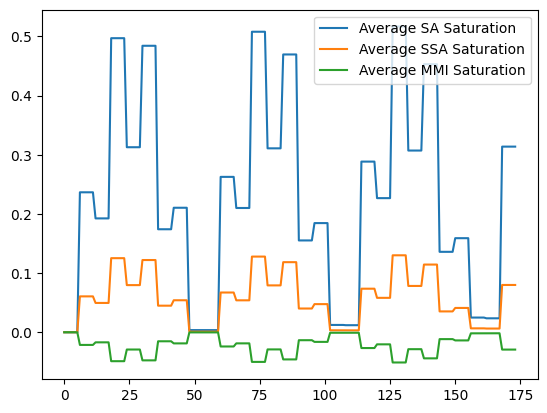

In [ ]:
groverAnalysis.plot_saturations()

In [25]:
str('0'*4)

'0000'

In [26]:
str('0'*(len(bin(goal)[2:])-num_qubits))+bin(goal)[2:]

'111'

In [29]:
num_qubits = 3
for goal in range(2**num_qubits):
    print(str('0'*(num_qubits - len(bin(goal)[2:])))+bin(goal)[2:])

000
001
010
011
100
101
110
111


In [39]:
ensemble_avg_sa = []
ensemble_avg_ssa = []
ensemble_avg_mmi = []
ensemble_avg_ent_norm = []
num_qubits = 3
num_iterations = 6
for goal in range(2**num_qubits):
    analysis = grovers(str('0'*(num_qubits - len(bin(goal)[2:])))+bin(goal)[2:],num_iterations)
    ensemble_avg_sa.append(analysis.avg_sas)
    ensemble_avg_ssa.append(analysis.avg_ssas)
    ensemble_avg_mmi.append(analysis.avg_mmis)
    ensemble_avg_ent_norm.append(analysis.norms)

    



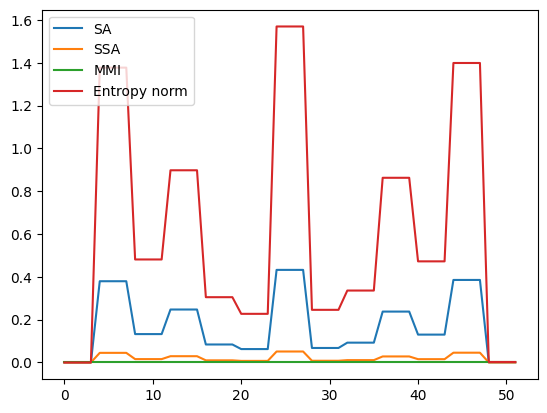

In [41]:
plt.plot(np.mean(np.array(ensemble_avg_sa),axis=0),label="SA")
plt.plot(np.mean(np.array(ensemble_avg_ssa),axis=0),label="SSA")
plt.plot(np.mean(np.array(ensemble_avg_mmi),axis=0),label="MMI")
plt.plot(np.mean(np.array(ensemble_avg_ent_norm),axis=0),label="Entropy norm")
plt.legend(loc='upper left')
plt.show()

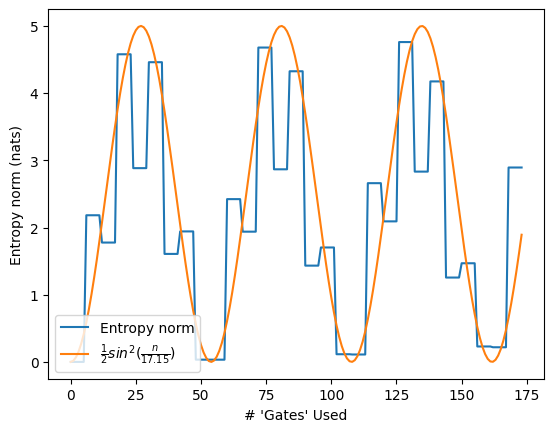

In [ ]:
plt.plot(groverAnalysis.norms, label="Entropy norm")
t = np.arange(len(groverAnalysis.avg_mmis))
plt.plot(5*np.sin(t/17.15)**2,label=r'$\frac{1}{2}sin^2(\frac{n}{17.15})$')
plt.xlabel("# 'Gates' Used")
plt.ylabel("Entropy norm (nats)")
plt.legend()

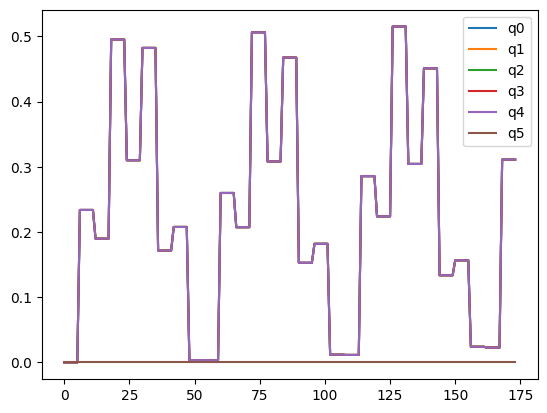

In [ ]:
groverAnalysis.plot_single_qubit_entropy()

### Quantum Fourier Transform

In [42]:
def qft(initial_state, analysis=None):
        
        N = int(np.log2(len(initial_state)))
        
        

        if analysis == None:
                # Construct the circuit
                qr = QuantumRegister(N) #+1 for ancilla
                cr = ClassicalRegister(N)
                qftCircuit = QuantumCircuit(qr,cr) 
                qftCircuit.initialize(initial_state,qftCircuit.qubits)
                qftAnalysis = EntropyAnalysis(N)
        else:
                qftAnalysis = analysis
                qftCircuit = analysis.circuit
        
        # Begin the QFT

        for i in range(N):
            qftCircuit.h(i)
            qftAnalysis.subsysem_analysis(qftCircuit)
            qftCircuit.barrier()
            
            for k in range(2,N-i+1):
                qftCircuit.cp(2*np.pi/2**k,i+(k-1),i)
                qftAnalysis.subsysem_analysis(qftCircuit)
                qftCircuit.barrier()


        for qub in range(int(N/2)):
                qftCircuit.swap(qub,N-1-qub)
        qftCircuit = qftCircuit.reverse_bits()
        #for ease i check if the actual statevector is indeed correct, rather than simulaitng, measuring, and taking square roots
        qftAnalysis.statevec = quantum_info.Statevector(qftCircuit) 
        #qftCircuit.measure(qr,cr)
        qftAnalysis.set_circuit(qftCircuit)
        
        return qftAnalysis

     

In [ ]:
num_qubits = 3
initial_state = np.random.rand(1,2**num_qubits)[0]
initial_state = initial_state/np.linalg.norm(initial_state)
qftAnalysis = qft(initial_state)
print(qftAnalysis.statevec)


Statevector([ 0.85346786+0.j        , -0.02182605+0.08205208j,
              0.00856624+0.05742575j,  0.29259264+0.03533761j,
             -0.27697326+0.j        ,  0.29259264-0.03533761j,
              0.00856624-0.05742575j, -0.02182605-0.08205208j],
            dims=(2, 2, 2))


In [47]:
num_qubits = 3

ensemble_avg_sa = []
ensemble_avg_ssa = []
ensemble_avg_mmi = []
ensemble_avg_ent_norm = []

for trial in range(100):
    initial_state = np.random.rand(1,2**num_qubits)[0]
    initial_state = initial_state/np.linalg.norm(initial_state)
    analysis = qft(initial_state)
    ensemble_avg_sa.append(analysis.avg_sas)
    ensemble_avg_ssa.append(analysis.avg_ssas)
    ensemble_avg_mmi.append(analysis.avg_mmis)
    ensemble_avg_ent_norm.append(analysis.norms)


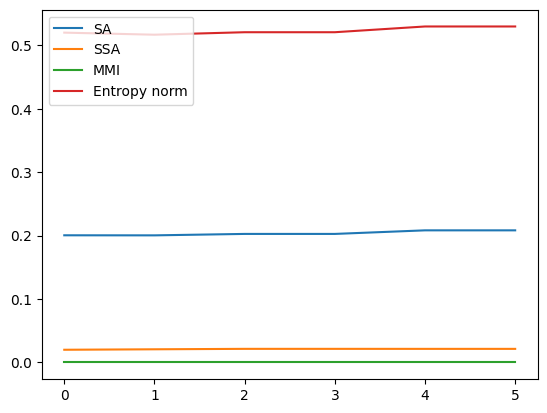

In [48]:
plt.plot(np.mean(np.array(ensemble_avg_sa),axis=0),label="SA")
plt.plot(np.mean(np.array(ensemble_avg_ssa),axis=0),label="SSA")
plt.plot(np.mean(np.array(ensemble_avg_mmi),axis=0),label="MMI")
plt.plot(np.mean(np.array(ensemble_avg_ent_norm),axis=0),label="Entropy norm")
plt.legend(loc='upper left')
plt.show()

In [ ]:
for e in qftAnalysis.entropies:
    print(e)

[0.4204359374256069, 0.32866677007959977, 3.330669073875469e-16, 0.3756003823473046, 0.37560038234730486, 0.42043593742560564, 0.32866677007959927]
[0.41509475022710196, 0.32866677007959977, 3.330669073875469e-16, 0.3114066097149911, 0.31140660971499173, 0.4150947502271022, 0.32866677007959927]
[0.4550838766631691, 0.3162932407497867, 3.330669073875469e-16, 0.3114066097149911, 0.31140660971499173, 0.45508387666316885, 0.316293240749787]
[0.45508387666316835, 0.3162932407497869, 4.440892098500625e-16, 0.3114066097149911, 0.311406609714991, 0.45508387666316885, 0.31629324074978765]
[0.45508387666316946, 0.28257796791398604, 4.440892098500625e-16, 0.32620167127525923, 0.3262016712752599, 0.45508387666316885, 0.2825779679139857]
[0.45508387666316874, 0.28257796791398654, 7.771561172376093e-16, 0.32620167127525945, 0.3262016712752597, 0.45508387666316896, 0.28257796791398615]


/home/dylan/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


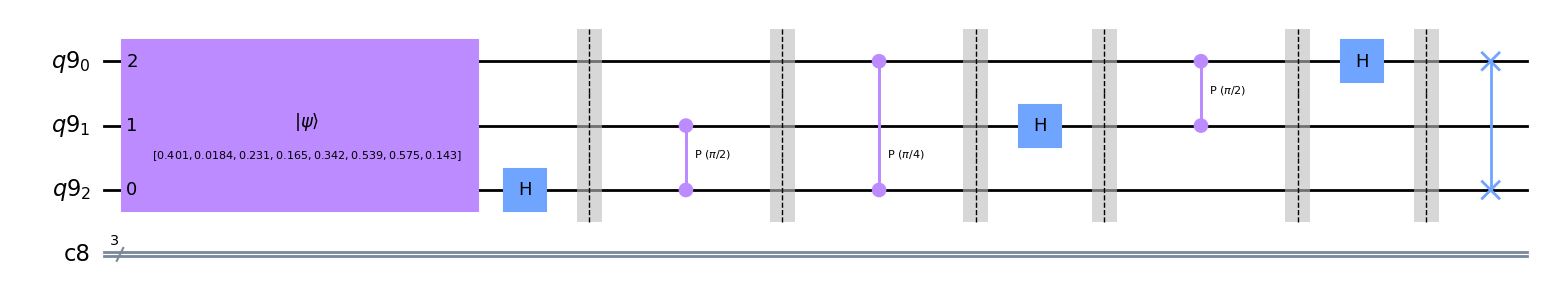

In [ ]:
qftAnalysis.circuit.draw('mpl')

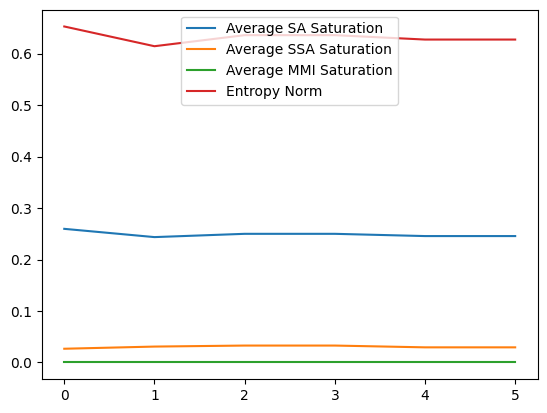

In [ ]:
qftAnalysis.plot_saturations()

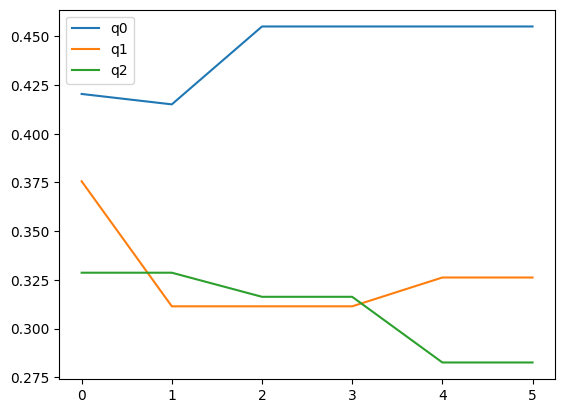

In [ ]:
qftAnalysis.plot_single_qubit_entropy()

In [ ]:
evenList = ['A','B','C','D','E','F','G','H','I']
oddList = ['A','B','C','D','E','F','G','H','I','J']

def totalswap(l):
    for i in range(int(len(l)/2)):
        temp = l[i]
        l[i] = l[len(l)-1-i]
        l[len(l)-1-i] = temp
    return l
print(totalswap(evenList))
print(totalswap(oddList))


['I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']
['J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']


In [ ]:
num_qubits = 5


initial_state = np.random.rand(1,2**num_qubits)[0]
initial_state = initial_state/np.linalg.norm(initial_state)
three_qub_qft = qft(initial_state)
final_state = quantum_info.Statevector(initial_state).evolve(quantum_info.Operator(three_qub_qft.circuit))



#for ease i check if the actual statevector is indeed correct, rather than simulaitng, measuring, and taking square roots
def dft(x):
    N=len(x)
    y = np.repeat(0+0j,N)
    for k in range(N):
        for n in range(N):
            y[k] = y[k] + x[n]*np.exp(1j*2*np.pi*k*n/N)
    return y/(N**.5)

dft_result = dft(initial_state)
#here i check if dft is off from qft:

fails = 0
for i in range(len(initial_state)):
    if abs(final_state[i] - dft_result[i]) > 1e-10:
        fails = fails+1
print("Fail %",fails/len(initial_state)*100)

(-0+0j)
0j
-0j
0j
0j
0j
-0j
(-0+0j)
-0j
(-0-0j)
-0j
-0j
-0j
(-0+0j)
(-0+0j)
(-0-0j)
(-0+0j)
(-0-0j)
(-0+0j)
-0j
-0j
(-0-0j)
(-0+0j)
0j
0j
(-0-0j)
(-0+0j)
-0j
(-0-0j)
-0j
(-0-0j)
(-0-0j)
Fail % 0.0


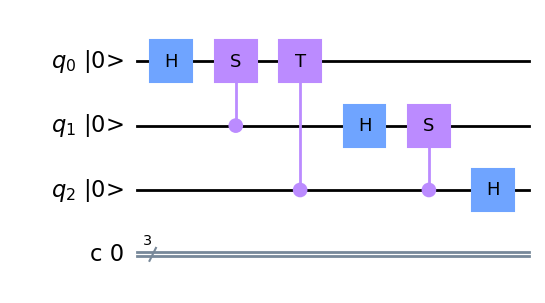

In [ ]:

N = 3
ct = TGate().control(1)    
# Construct the circuit
qr = QuantumRegister(N,'q') 
cr = ClassicalRegister(N,'c')
qftCircuit = QuantumCircuit(qr,cr) 
#qftCircuit.initialize(initial_state,qftCircuit.qubits)

qftAnalysis = EntropyAnalysis(N)

# Begin the QFT

qftCircuit.h(0)
qftCircuit.cs(1,0)
qftCircuit.append(ct,[2,0])
qftCircuit.h(1)
qftCircuit.cs(2,1)
qftCircuit.h(2)
#qftCircuit.swap(0,2)
#qftCircuit = qftCircuit.reverse_bits()
#qftCircuit.barrier()
#qftCircuit.measure(qr,cr)
qftAnalysis.set_circuit(qftCircuit)
qftCircuit.draw('mpl',plot_barriers=False,initial_state=True)


In [ ]:

noswaps = quantum_info.Operator(qftCircuit).data
qftCircuit.swap(0,2)
qftCircuit = qftCircuit.reverse_bits()
withswaps = quantum_info.Operator(qftCircuit).data
display(sp.Matrix(np.round(noswaps-withswaps,2)))

Matrix([
[0,              0, 0,             0,             0, 0,              0, 0],
[0,   0.6 + 0.25*I, 0, -0.25 + 0.6*I, -0.6 - 0.25*I, 0,   0.25 - 0.6*I, 0],
[0, -0.35 + 0.35*I, 0, 0.35 - 0.35*I, 0.35 - 0.35*I, 0, -0.35 + 0.35*I, 0],
[0,   0.1 + 0.25*I, 0,  0.25 - 0.1*I, -0.1 - 0.25*I, 0,  -0.25 + 0.1*I, 0],
[0,          -0.71, 0,         -0.71,          0.71, 0,           0.71, 0],
[0,   0.1 - 0.25*I, 0,  0.25 + 0.1*I, -0.1 + 0.25*I, 0,  -0.25 - 0.1*I, 0],
[0, -0.35 - 0.35*I, 0, 0.35 + 0.35*I, 0.35 + 0.35*I, 0, -0.35 - 0.35*I, 0],
[0,   0.6 - 0.25*I, 0, -0.25 - 0.6*I, -0.6 + 0.25*I, 0,   0.25 + 0.6*I, 0]])

In [ ]:
import sympy as sp
omega = np.sqrt(0.+1.j)
op = np.array([[1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j],
          [1.0+0.j,omega,omega**2,omega**3,omega**4,omega**5,omega**6,omega**7],
          [1.0+0.j,omega**2,omega**4,omega**6,1.0+0.j,omega**2,omega**4,omega**6],
          [1.0+0.j,omega**3,omega**6,omega**1,omega**4,omega**7,omega**2,omega**5],
          [1.0+0.j,omega**4,1.0+0.j,omega**4,1.0+0.j,omega**4,1.+0.j,omega**4],
          [1.0+0.j,omega**5,omega**2,omega**7,omega**4,omega**1,omega**6,omega**3],
          [1.0+0.j,omega**6,omega**4,omega**2,1.0+0.j,omega**6,omega**4,omega**2],
          [1.0+0.j,omega**7,omega**6,omega**5,omega**4,omega**3,omega**2,omega**1]])/np.sqrt(8)
myop = quantum_info.Operator(qftCircuit).data
display(sp.Matrix(np.round(op-myop,4)))


Matrix([
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:

#for ease i check if the actual statevector is indeed correct, rather than simulaitng, measuring, and taking square roots
initial_state = np.random.rand(1,2**num_qubits)[0]
initial_state = initial_state/np.linalg.norm(initial_state)
final_state = quantum_info.Statevector(initial_state).evolve(quantum_info.Operator(qftCircuit))

def dft(x):
    N=len(x)
    y = np.repeat(0+0j,N)
    for k in range(N):
        for n in range(N):
            y[k] = y[k] + x[n]*np.exp(1j*2*np.pi*k*n/N)
    return y/(N**.5)

dft_result = dft(initial_state)
#here i check if dft is off from qft:

fails = 0
for i in range(len(initial_state)):
    print(np.round(final_state[i] - dft_result[i],10))
    if abs(final_state[i] - dft_result[i]) > 1e-10:
        fails = fails+1
print("Fail %",fails/len(initial_state)*100)




(-0+0j)
0j
-0j
0j
-0j
-0j
0j
(-0-0j)
Fail % 0.0


In [ ]:

#display(sp.Matrix(np.round(op-,3)))

Matrix([
[0,                  0, 0,                 0,                 0, 0,                  0, 0],
[0,    0.6036 + 0.25*I, 0,  -0.25 + 0.6036*I,  -0.6036 - 0.25*I, 0,    0.25 - 0.6036*I, 0],
[0, -0.3536 + 0.3536*I, 0, 0.3536 - 0.3536*I, 0.3536 - 0.3536*I, 0, -0.3536 + 0.3536*I, 0],
[0,    0.1036 + 0.25*I, 0,   0.25 - 0.1036*I,  -0.1036 - 0.25*I, 0,   -0.25 + 0.1036*I, 0],
[0,            -0.7071, 0,           -0.7071,            0.7071, 0,             0.7071, 0],
[0,    0.1036 - 0.25*I, 0,   0.25 + 0.1036*I,  -0.1036 + 0.25*I, 0,   -0.25 - 0.1036*I, 0],
[0, -0.3536 - 0.3536*I, 0, 0.3536 + 0.3536*I, 0.3536 + 0.3536*I, 0, -0.3536 - 0.3536*I, 0],
[0,    0.6036 - 0.25*I, 0,  -0.25 - 0.6036*I,  -0.6036 + 0.25*I, 0,    0.25 + 0.6036*I, 0]])

In [ ]:

display(sp.Matrix(myop))

Matrix([
[                         0.353553390593274,                           0.353553390593274,                           0.353553390593274,                           0.353553390593274,  0.353553390593274 + 1.38777878078145e-17*I,  0.353553390593274 + 1.38777878078145e-17*I,  0.353553390593274 + 1.38777878078145e-17*I,  0.353553390593274 + 1.38777878078145e-17*I],
[0.353553390593274 - 1.38777878078145e-17*I, -0.353553390593274 + 1.38777878078145e-17*I,  1.38777878078145e-17 + 0.353553390593274*I, -1.38777878078145e-17 - 0.353553390593274*I,                               0.25 + 0.25*I,                              -0.25 - 0.25*I,                              -0.25 + 0.25*I,                               0.25 - 0.25*I],
[                         0.353553390593274,                           0.353553390593274,                          -0.353553390593274,                          -0.353553390593274, -1.38777878078145e-17 + 0.353553390593274*I, -1.38777878078145e-17 + 0.353553390593274*I,

In [ ]:
display(sp.Matrix(np.round(myop-op,5)))

Matrix([
[0,                   0, 0,                    0,                    0, 0,                   0, 0],
[0,   -0.60355 - 0.25*I, 0,     0.25 - 0.60355*I,     0.60355 + 0.25*I, 0,   -0.25 + 0.60355*I, 0],
[0, 0.35355 - 0.35355*I, 0, -0.35355 + 0.35355*I, -0.35355 + 0.35355*I, 0, 0.35355 - 0.35355*I, 0],
[0,   -0.10355 - 0.25*I, 0,    -0.25 + 0.10355*I,     0.10355 + 0.25*I, 0,    0.25 - 0.10355*I, 0],
[0,             0.70711, 0,              0.70711,             -0.70711, 0,            -0.70711, 0],
[0,   -0.10355 + 0.25*I, 0,    -0.25 - 0.10355*I,     0.10355 - 0.25*I, 0,    0.25 + 0.10355*I, 0],
[0, 0.35355 + 0.35355*I, 0, -0.35355 - 0.35355*I, -0.35355 - 0.35355*I, 0, 0.35355 + 0.35355*I, 0],
[0,   -0.60355 + 0.25*I, 0,     0.25 + 0.60355*I,     0.60355 - 0.25*I, 0,   -0.25 - 0.60355*I, 0]])

In [ ]:
omega = sp.symbols('omega')
display(sp.Matrix([[1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j,1.+0.j],
          [1.0+0.j,omega,omega**2,omega**3,omega**4,omega**5,omega**6,omega**7],
          [1.0+0.j,omega**2,omega**4,omega**6,1.0+0.j,omega**2,omega**4,omega**6],
          [1.0+0.j,omega**3,omega**6,omega**1,omega**4,omega**7,omega**2,omega**5],
          [1.0+0.j,omega**4,1.0+0.j,omega**4,1.0+0.j,omega**4,1.+0.j,omega**4],
          [1.0+0.j,omega**5,omega**2,omega**7,omega**4,omega**1,omega**6,omega**3],
          [1.0+0.j,omega**6,omega**4,omega**2,1.0+0.j,omega**6,omega**4,omega**2],
          [1.0+0.j,omega**7,omega**6,omega**5,omega**4,omega**3,omega**2,omega**1]]))

Matrix([
[1.0,      1.0,      1.0,      1.0,      1.0,      1.0,      1.0,      1.0],
[1.0,    omega, omega**2, omega**3, omega**4, omega**5, omega**6, omega**7],
[1.0, omega**2, omega**4, omega**6,      1.0, omega**2, omega**4, omega**6],
[1.0, omega**3, omega**6,    omega, omega**4, omega**7, omega**2, omega**5],
[1.0, omega**4,      1.0, omega**4,      1.0, omega**4,      1.0, omega**4],
[1.0, omega**5, omega**2, omega**7, omega**4,    omega, omega**6, omega**3],
[1.0, omega**6, omega**4, omega**2,      1.0, omega**6, omega**4, omega**2],
[1.0, omega**7, omega**6, omega**5, omega**4, omega**3, omega**2,    omega]])

In [ ]:
print(omega)

(0.7071067811865476+0.7071067811865476j)


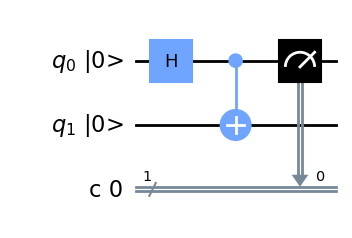

In [ ]:
#Test entanglement of controlled z 2 qubits
qr = QuantumRegister(2,'q') #+1 for ancilla
cr = ClassicalRegister(1,'c')
testcircuit = QuantumCircuit(qr,cr) 

testanalysis = EntropyAnalysis(2)

# Begin the QFT
testanalysis.subsysem_analysis(testcircuit)
testcircuit.h(0)
testanalysis.subsysem_analysis(testcircuit)
testcircuit.cx(0,1)
testanalysis.subsysem_analysis(testcircuit)
testanalysis.set_statevec(quantum_info.Statevector(testcircuit))
testcircuit.measure(qr[0],cr)
testanalysis.set_circuit(testcircuit)
testcircuit.draw('mpl',plot_barriers=False,initial_state=True,style="clifford")


In [ ]:
def qpe(U,analysis=None):
    if analysis = None:
    cU = qi.Operator(U)
    
    
    

In [4]:
cnot = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
np.linalg.eig(cnot)

EigResult(eigenvalues=array([ 1., -1.,  1.,  1.]), eigenvectors=matrix([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.70710678, -0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ]]))

In [66]:
np.linalg.eig(cnot).eigenvectors

matrix([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.70710678, -0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ]])

In [9]:
np.linalg.eig(cnot).eigenvalues[1]

-1.0

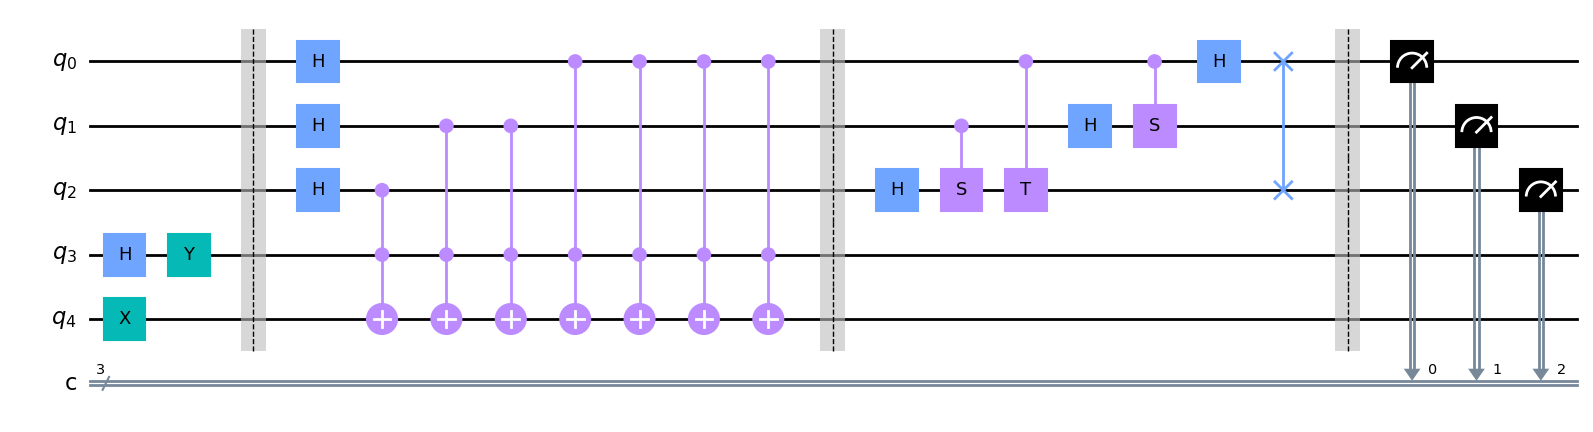

In [5]:
n = 3 #num qubits to perform QPE
m = 2 #num qubits to create the eigenvector of U = CNOT
ct = TGate().control()
qr = QuantumRegister(n+m,'q') #+1 for ancilla
cr = ClassicalRegister(n,'c')
testcircuit = QuantumCircuit(qr,cr) 
# here i just construct the -1 eigenvector of U = CNOT
testcircuit.x(n+1)
testcircuit.h(n+0)
# testcircuit.x(0)
# testcircuit.z(0)
# testcircuit.x(0)
testcircuit.y(n+0)
testcircuit.barrier()
for i in range(n):
    testcircuit.h(i)
for i in range(n-1,-1,-1):
    #ctrl_cnot = CXGate.control(i)
    for j in range(2**(n-i-1)):
        #testcircuit.append(ctrl_cnot,qr)
        testcircuit.ccx(i,n+m-2,n+m-1)
testcircuit.barrier()
#testcircuit.swap(0,2)
testcircuit.h(2)
testcircuit.cs(1,2)
testcircuit.append(ct,[0,2])
testcircuit.h(1)
testcircuit.cs(0,1)
testcircuit.h(0)
#testcircuit.swap(0,2)
#testcircuit.reverse_bits()
testcircuit.barrier()
testcircuit.measure(qr[:3],cr)

testcircuit.draw('mpl')


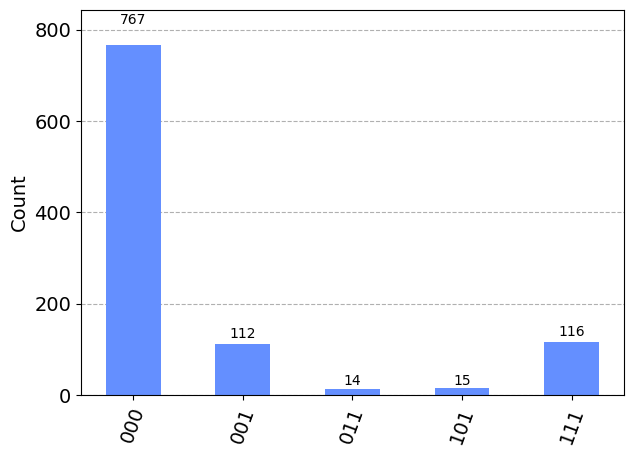

In [6]:

from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
simulator = Aer.get_backend('aer_simulator')

testcircuit = transpile(testcircuit, simulator)
result = simulator.run(testcircuit).result()
counts = result.get_counts(testcircuit)
plot_histogram(counts)

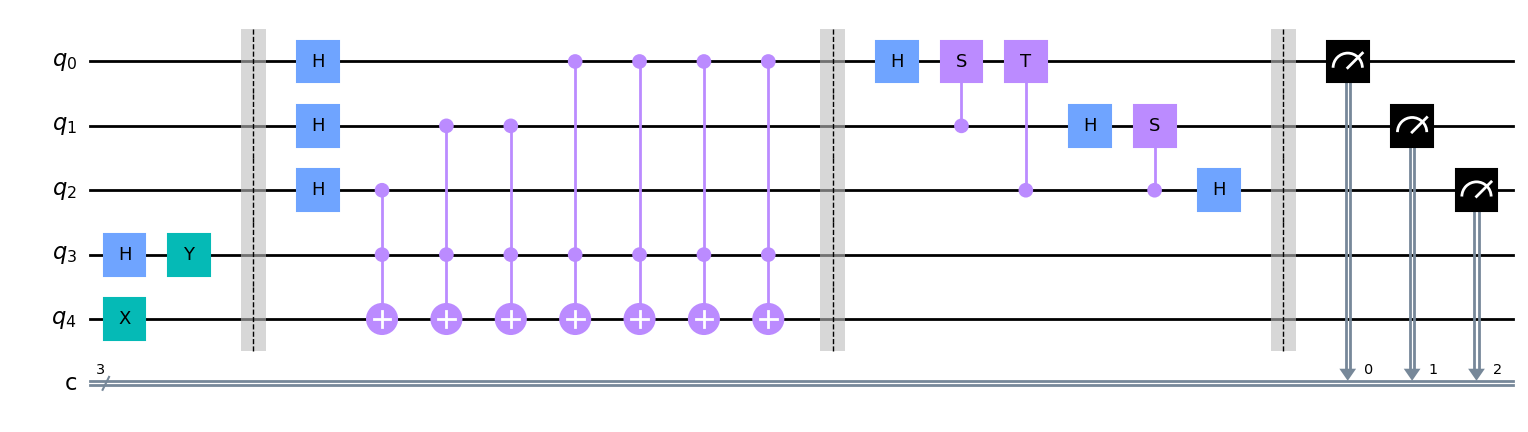

In [3]:
n = 3 #num qubits to perform QPE
m = 2 #num qubits to create the eigenvector of U = CNOT
ct = TGate().control()
qr = QuantumRegister(n+m,'q') #+1 for ancilla
cr = ClassicalRegister(n,'c')
testcircuit = QuantumCircuit(qr,cr) 
# here i just construct the -1 eigenvector of U = CNOT
testcircuit.x(n+1)
testcircuit.h(n+0)
# testcircuit.x(0)
# testcircuit.z(0)
# testcircuit.x(0)
testcircuit.y(n+0)
testcircuit.barrier()
for i in range(n):
    testcircuit.h(i)
for i in range(n-1,-1,-1):
    #ctrl_cnot = CXGate.control(i)
    for j in range(2**(n-i-1)):
        #testcircuit.append(ctrl_cnot,qr)
        testcircuit.ccx(i,n+m-2,n+m-1)
testcircuit.barrier()
#testcircuit.swap(0,2)
testcircuit.h(0)
testcircuit.cs(1,0)
testcircuit.append(ct,[2,0])
testcircuit.h(1)
testcircuit.cs(2,1)
testcircuit.h(2)
#testcircuit.swap(0,2)
#testcircuit.reverse_bits()
testcircuit.barrier()
testcircuit.measure(qr[:3],cr)

testcircuit.draw('mpl')


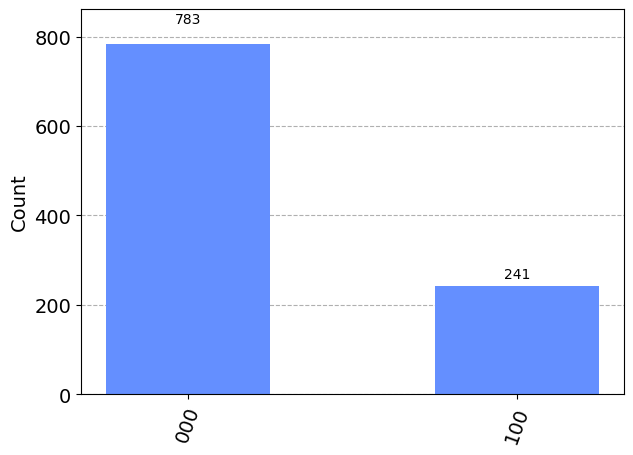

In [31]:

simulator = Aer.get_backend('aer_simulator')

testcircuit = transpile(testcircuit, simulator)
result = simulator.run(testcircuit).result()
counts = result.get_counts(testcircuit)
plot_histogram(counts)

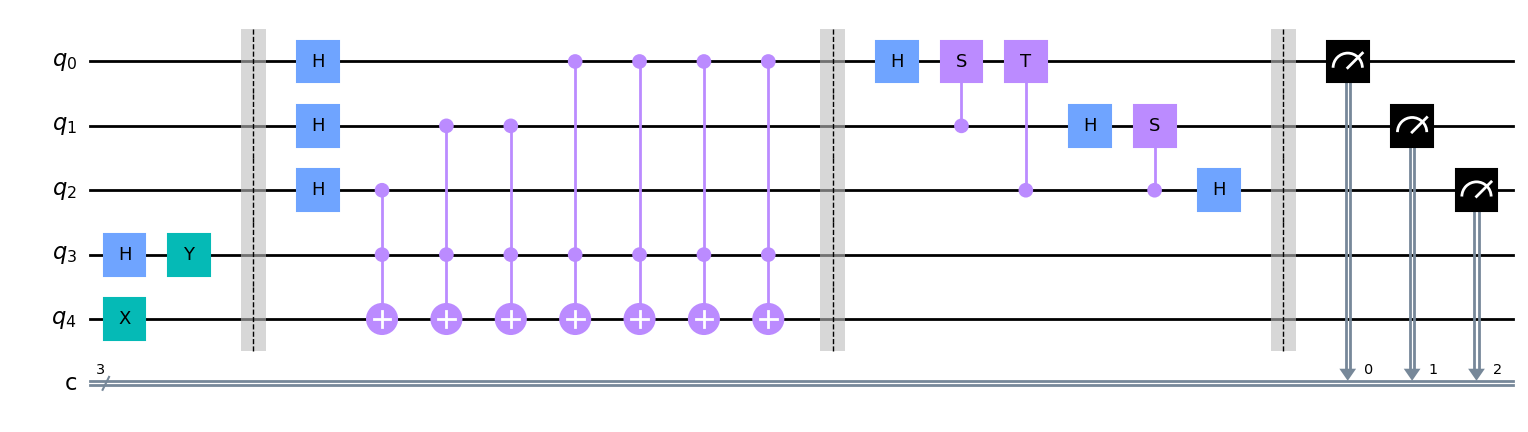

In [4]:
n = 3 #num qubits to perform QPE
m = 2 #num qubits to create the eigenvector of U = CNOT
ct = TGate().control()
qr = QuantumRegister(n+m,'q') #+1 for ancilla
cr = ClassicalRegister(n,'c')
testcircuit = QuantumCircuit(qr,cr) 
# here i just construct the -1 eigenvector of U = CNOT
testcircuit.x(n+1)
testcircuit.h(n+0)
# testcircuit.x(0)
# testcircuit.z(0)
# testcircuit.x(0)
testcircuit.y(n+0)
testcircuit.barrier()
for i in range(n):
    testcircuit.h(i)
for i in range(n-1,-1,-1):
    #ctrl_cnot = CXGate.control(i)
    for j in range(2**(n-i-1)):
        #testcircuit.append(ctrl_cnot,qr)
        testcircuit.ccx(i,n+m-2,n+m-1)
testcircuit.barrier()
#testcircuit.swap(0,2)
testcircuit.h(0)
testcircuit.cs(1,0)
testcircuit.append(ct,[2,0])
testcircuit.h(1)
testcircuit.cs(2,1)
testcircuit.h(2)
#testcircuit.swap(0,2)
#testcircuit.reverse_bits()
testcircuit.barrier()
testcircuit.measure(qr[:3],cr)

testcircuit.draw('mpl')


In [9]:
u00,u01,u10,u11 = sp.symbols("u_00,u_01,u_10,u_11")
U=sp.Matrix([[u00,u01],[u10,u11]])
CU=sp.Matrix([[1,0,0,0],[0,1,0,0],[0,0,u00,u01],[0,0,u10,u11]])
U**2

Matrix([
[  u_00**2 + u_01*u_10, u_00*u_01 + u_01*u_11],
[u_00*u_10 + u_10*u_11,   u_01*u_10 + u_11**2]])

In [14]:
CU**2

Matrix([
[1, 0,                     0,                     0],
[0, 1,                     0,                     0],
[0, 0,   u_00**2 + u_01*u_10, u_00*u_01 + u_01*u_11],
[0, 0, u_00*u_10 + u_10*u_11,   u_01*u_10 + u_11**2]])

In [28]:
U**4

Matrix([
[                    u_00**4 + 3*u_00**2*u_01*u_10 + 2*u_00*u_01*u_10*u_11 + u_01**2*u_10**2 + u_01*u_10*u_11**2, u_00**3*u_01 + u_00**2*u_01*u_11 + 2*u_00*u_01**2*u_10 + u_00*u_01*u_11**2 + 2*u_01**2*u_10*u_11 + u_01*u_11**3],
[u_00**3*u_10 + u_00**2*u_10*u_11 + 2*u_00*u_01*u_10**2 + u_00*u_10*u_11**2 + 2*u_01*u_10**2*u_11 + u_10*u_11**3,                     u_00**2*u_01*u_10 + 2*u_00*u_01*u_10*u_11 + u_01**2*u_10**2 + 3*u_01*u_10*u_11**2 + u_11**4]])

In [29]:
CU**4

Matrix([
[1, 0,                                                                                                               0,                                                                                                               0],
[0, 1,                                                                                                               0,                                                                                                               0],
[0, 0,                     u_00**4 + 3*u_00**2*u_01*u_10 + 2*u_00*u_01*u_10*u_11 + u_01**2*u_10**2 + u_01*u_10*u_11**2, u_00**3*u_01 + u_00**2*u_01*u_11 + 2*u_00*u_01**2*u_10 + u_00*u_01*u_11**2 + 2*u_01**2*u_10*u_11 + u_01*u_11**3],
[0, 0, u_00**3*u_10 + u_00**2*u_10*u_11 + 2*u_00*u_01*u_10**2 + u_00*u_10*u_11**2 + 2*u_01*u_10**2*u_11 + u_10*u_11**3,                     u_00**2*u_01*u_10 + 2*u_00*u_01*u_10*u_11 + u_01**2*u_10**2 + 3*u_01*u_10*u_11**2 + u_11**4]])

Analytical form of QPE

/home/dylan/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


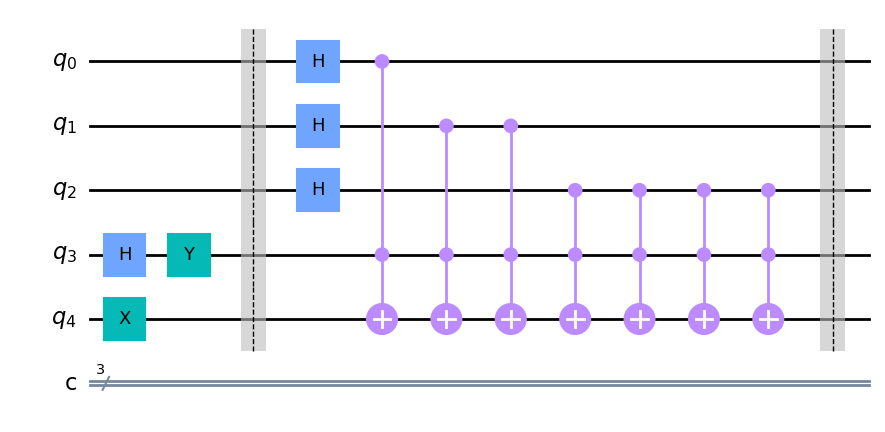

In [51]:
n = 3 #num qubits to perform QPE
m = 2 #num qubits to create the eigenvector of U = CNOT
ct = TGate().control()
qr = QuantumRegister(n+m,'q') 
cr = ClassicalRegister(n,'c')
testcircuit = QuantumCircuit(qr,cr) 
# here i just construct the -1 eigenvector of U = CNOT
testcircuit.x(n+1)
testcircuit.h(n+0)
# testcircuit.x(0)
# testcircuit.z(0)
# testcircuit.x(0)
testcircuit.y(n+0)
testcircuit.barrier()
for i in range(n):
    testcircuit.h(i)
for i in reversed(range(n-1,-1,-1)):
    #ctrl_cnot = CXGate.control(i)
    for j in range(2**(i)):
        #testcircuit.append(ctrl_cnot,qr)
        testcircuit.ccx(i,n+m-2,n+m-1)
qpeOperator = quantum_info.Operator(testcircuit).data
testcircuit.barrier()
#start inverse QFT
#testcircuit.swap(0,2)
# testcircuit.h(0)
# testcircuit.cs(1,0)
# testcircuit.append(ct,[2,0])
# testcircuit.h(1)
# testcircuit.cs(2,1)
# testcircuit.h(2)
# testcircuit.swap(0,2)
# testcircuit.reverse_bits()
# testcircuit.barrier()
# testcircuit.measure(qr[:3],cr)

testcircuit.draw('mpl')


In [52]:
op = sp.Matrix(qpeOperator)
op

Matrix([
[      0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,       0, -0.25*I, -0.25*I, -0.25*I, -0.25*I, -0.25*I, -0.25*I, -0.25*I, -0.25*I, 0.25*I,  0.25*I,  0.25*I,  0.25*I,  0.25*I,  0.25*I,  0.25*I,  0.25*I],
[      0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,       0, -0.25*I,  0.25*I, -0.25*I,  0.25*I, -0.25*I,  0.25*I, -0.25*I,  0.25*I, 0.25*I, -0.25*I,  0.25*I, -0.25*I,  0.25*I, -0.25*I,  0.25*I, -0.25*I],
[      0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,       0,       0, -0.25*I, -0.25*I,  0.25*I,  0.25*I, -0.25*I, -0.25*I,  0.25*I,  0.25*I, 0.25*I,  0.25*I, -0.25*I, -0.25*I,  0.25*I,  0.25*I, -0.25*I, -0.25*I],
[      0,       0,       0,       0,       0,       0,       0,       0,      0,       0,       0,       0,       0,       0,  

In [53]:

q_10,q_11,q_20,q_21,q_30,q_31,q_40,q_41,q_50,q_51=sp.symbols("q_10,q_11,q_20,q_21,q_30,q_31,q_40,q_41,q_50,q_51")
j_vec = TensorProduct(sp.Matrix([q_10,q_11]),TensorProduct(sp.Matrix([q_20,q_21]),sp.Matrix([q_30,q_31])))
psi_vec = TensorProduct(sp.Matrix([q_40,q_41]),sp.Matrix([q_50,q_51]))
total_state = TensorProduct(j_vec,psi_vec)

In [54]:
op_vec = sp.simplify(op*total_state)
op_vec

Matrix([
[0.25*I*q_11*(-q_20*q_30*q_40*q_50 - q_20*q_30*q_40*q_51 - q_20*q_30*q_41*q_50 - q_20*q_30*q_41*q_51 - q_20*q_31*q_40*q_50 - q_20*q_31*q_40*q_51 - q_20*q_31*q_41*q_50 - q_20*q_31*q_41*q_51 + q_21*q_30*q_40*q_50 + q_21*q_30*q_40*q_51 + q_21*q_30*q_41*q_50 + q_21*q_30*q_41*q_51 + q_21*q_31*q_40*q_50 + q_21*q_31*q_40*q_51 + q_21*q_31*q_41*q_50 + q_21*q_31*q_41*q_51)],
[0.25*I*q_11*(-q_20*q_30*q_40*q_50 + q_20*q_30*q_40*q_51 - q_20*q_30*q_41*q_50 + q_20*q_30*q_41*q_51 - q_20*q_31*q_40*q_50 + q_20*q_31*q_40*q_51 - q_20*q_31*q_41*q_50 + q_20*q_31*q_41*q_51 + q_21*q_30*q_40*q_50 - q_21*q_30*q_40*q_51 + q_21*q_30*q_41*q_50 - q_21*q_30*q_41*q_51 + q_21*q_31*q_40*q_50 - q_21*q_31*q_40*q_51 + q_21*q_31*q_41*q_50 - q_21*q_31*q_41*q_51)],
[0.25*I*q_11*(-q_20*q_30*q_40*q_50 - q_20*q_30*q_40*q_51 + q_20*q_30*q_41*q_50 + q_20*q_30*q_41*q_51 - q_20*q_31*q_40*q_50 - q_20*q_31*q_40*q_51 + q_20*q_31*q_41*q_50 + q_20*q_31*q_41*q_51 + q_21*q_30*q_40*q_50 + q_21*q_30*q_40*q_51 - q_21*q_30*q_41*q_50 

In [55]:
#get hadamard op
qr = QuantumRegister(3,'q') 
cr = ClassicalRegister(3,'c')
Hcircuit = QuantumCircuit(qr,cr) 
Hcircuit.h(0)
Hcircuit.h(1)
Hcircuit.h(2)
H3matrix = quantum_info.Operator(Hcircuit).data

In [56]:
#get op to prepare eigvec
qr = QuantumRegister(2,'q') 
cr = ClassicalRegister(2,'c')
ecirc = QuantumCircuit(qr,cr)
ecirc.h(0)
ecirc.y(0)
ecirc.x(1)
psi_op = quantum_info.Operator(ecirc).data

$$\sum_{j=0}^{2^n-1}e^{2\pi i j \theta}|j\rangle$$

In [58]:
j_vec_ideal = j_vec
j_vec_ideal = H3matrix*j_vec
psi_vec_ideal = psi_op*psi_vec
for j in range(2**3):
    j_vec_ideal[j] = j_vec_ideal[j]*sp.exp(2*sp.pi*1j*j*0.5)
op_vec_ideal = sp.simplify(TensorProduct(j_vec_ideal,psi_vec_ideal))
op_vec_ideal

Matrix([
[-0.25*I*q_41*(q_50 - q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_20*q_30 + q_11*q_20*q_31 + q_11*q_21*q_30 + q_11*q_21*q_31)],
[ 0.25*I*q_41*(q_50 + q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_20*q_30 + q_11*q_20*q_31 + q_11*q_21*q_30 + q_11*q_21*q_31)],
[-0.25*I*q_40*(q_50 - q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_20*q_30 + q_11*q_20*q_31 + q_11*q_21*q_30 + q_11*q_21*q_31)],
[ 0.25*I*q_40*(q_50 + q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_20*q_30 + q_11*q_20*q_31 + q_11*q_21*q_30 + q_11*q_21*q_31)],
[ 0.25*I*q_41*(q_50 - q_51)*(q_10*q_20*q_30 - q_10*q_20*q_31 + q_10*q_21*q_30 - q_10*q_21*q_31 + q_11*q_20*q_30 - q_11*q_20*q_31 + q_11*q_21*q_30 - q_11*q_21*q_31)],
[-0.25*I*q_41*(q_50 + q_51)*(q_10*q_20*q_30 - q_10*q_20*q_31 + q_10*q_21*q_30 - q_10*q_21*q_31 + q_11*q_20*q_30 - q_11*q_20*q_31 + q_11*q_21*q_30 - q_11*q_21*q_3

In [59]:
sp.simplify(op_vec-op_vec_ideal)

Matrix([
[0.25*I*(-q_11*(q_20*q_30*q_40*q_50 + q_20*q_30*q_40*q_51 + q_20*q_30*q_41*q_50 + q_20*q_30*q_41*q_51 + q_20*q_31*q_40*q_50 + q_20*q_31*q_40*q_51 + q_20*q_31*q_41*q_50 + q_20*q_31*q_41*q_51 - q_21*q_30*q_40*q_50 - q_21*q_30*q_40*q_51 - q_21*q_30*q_41*q_50 - q_21*q_30*q_41*q_51 - q_21*q_31*q_40*q_50 - q_21*q_31*q_40*q_51 - q_21*q_31*q_41*q_50 - q_21*q_31*q_41*q_51) + q_41*(q_50 - q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_20*q_30 + q_11*q_20*q_31 + q_11*q_21*q_30 + q_11*q_21*q_31))],
[0.25*I*(-q_11*(q_20*q_30*q_40*q_50 - q_20*q_30*q_40*q_51 + q_20*q_30*q_41*q_50 - q_20*q_30*q_41*q_51 + q_20*q_31*q_40*q_50 - q_20*q_31*q_40*q_51 + q_20*q_31*q_41*q_50 - q_20*q_31*q_41*q_51 - q_21*q_30*q_40*q_50 + q_21*q_30*q_40*q_51 - q_21*q_30*q_41*q_50 + q_21*q_30*q_41*q_51 - q_21*q_31*q_40*q_50 + q_21*q_31*q_40*q_51 - q_21*q_31*q_41*q_50 + q_21*q_31*q_41*q_51) - q_41*(q_50 + q_51)*(q_10*q_20*q_30 + q_10*q_20*q_31 + q_10*q_21*q_30 + q_10*q_21*q_31 + q_11*q_

In [60]:
sp.simplify(op_vec-op_vec_ideal).subs([(q_10, 1), (q_20, 1), (q_30, 1),(q_40, 1), (q_50, 1), (q_11, 0), (q_21, 0), (q_31, 0),(q_41, 0), (q_51, 0)])

Matrix([
[      0],
[      0],
[ 0.25*I],
[-0.25*I],
[      0],
[      0],
[-0.25*I],
[ 0.25*I],
[      0],
[ 0.25*I],
[ 0.25*I],
[      0],
[      0],
[ 0.25*I],
[-0.25*I],
[  0.5*I],
[-0.25*I],
[-0.25*I],
[      0],
[ -0.5*I],
[-0.25*I],
[-0.25*I],
[ -0.5*I],
[      0],
[ 0.25*I],
[      0],
[  0.5*I],
[-0.25*I],
[ 0.25*I],
[      0],
[      0],
[ 0.25*I]])

In [22]:

a,b,c,d = sp.symbols('a,b,c,d')
vec = sp.Matrix([a,b,c,d])

def swap(vec, bit1, bit2):
    swapmatrix = np.eye(len(vec))
    temp = swapmatrix[bit1].copy()
    swapmatrix[bit1] = swapmatrix[bit2]
    swapmatrix[bit2] = temp
    print(swapmatrix)
    return swapmatrix@vec

swap(vec,2,3)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


Matrix([
[1.0*a],
[1.0*b],
[1.0*d],
[1.0*c]])

In [6]:
def h(vec,):

NameError: name 'temp' is not defined

In [23]:
class QCircuit:
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        self.statevector = np.zeros(2**num_qubits)
        self.statevector[0] = 1.
        self.density_matrix = np.eye(2**num_qubits)
    def swap(self, qubit_A, qubit_B):
        
    def h(self, qubit):
        h_as_matrix = 1.
        for i in range(qubit-1):
            h_as_matrix = np.tensordot(h_as_matrix,np.eye(2))
        h_as_matrix = np.tensordot(h_as_matrix,np.matrix([[1.,1.],[1.,-1.]])/np.sqrt(2))
        for i in range(qubit+1,self.num_qubits):
            h_as_matrix = np.tensordot(h_as_matrix,np.eye(2))
            
mycirc = QCircuit(4)
mycirc.h(3)

     

IndexError: tuple index out of range

In [4]:

qubit_map = {'0':np.array([1,0]),'1':np.array([0,1])}

def int_to_bitstring(i,length):
    bitstring = bin(i)[2:]
    bitlength = len(bitstring)
    if bitlength < length:
        for j in range(length-bitlength):
            bitstring = '0'+bitstring
    return bitstring

def f_cnot(bitstring,control,target):
    if bitstring[control] == '1':
        bitstring = bitstring[:target] + str(1-int(bitstring[target]))+bitstring[1+target:]
    return bitstring

print(f_cnot('1110',0,3))
    

1111


In [13]:
# construct the 'lgm' matrix by finding how each binary string transforms under the unitary

def get_full_cnot(num_qubits,control,target):
    lgm = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        transformed_bitstring = f_cnot(int_to_bitstring(bitint,num_qubits),control,target)
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm
            
print(get_full_cnot(4,1,3))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [7]:
def f_swaps(bitstring,swap_from,swap_to):
    num_swaps = len(swap_from)
    for i in range(num_swaps):
        temp = bitstring[swap_from[i]]
        #bitstring[swap_from[i]] = bitstring[swap_to[i]]
        bitstring = bitstring[:swap_from[i]] + bitstring[swap_to[i]] +bitstring[1+swap_from[i]:]
        #bitstring[swap_to[i]] = temp
        bitstring = bitstring[:swap_to[i]] + temp +bitstring[1+swap_to[i]:]
    return bitstring
f_swaps('110101',[2,5],[3,4])

'111010'

In [48]:
def bitstrings_to_vector(bitstrings):
    if type(bitstrings) == dict:
        num_bits = len(list(bitstrings)[0])
        vec = np.zeros(2**num_bits)
        for bitstring in bitstrings:
            this_vec = np.array(1.)
            for bit in bitstring:
                this_vec = np.kron(this_vec,qubit_map[bit])
            vec = vec + bitstrings[bitstring]*this_vec
        return vec
    else:
        num_bits = len(bitstrings)
        vec = np.array(1.)
        for bit in bitstrings:
            vec = np.kron(vec,qubit_map[bit])
        return vec
def bitstrings_dict_from_vector(vec):
    num_bits = int(np.log2(len(vec)))
    state = dict()
    for i in range(len(vec)):
        state[int_to_bitstring(i,num_bits)] = vec[i]
    return state

def bitstring_to_dict(bitstring):
    bitstrings = dict()
    num_bits = len(bitstring)
    for i in range(2**num_bits):
        bitstrings[int_to_bitstring(i,num_bits)] = 0
        bitstrings[bitstring] = 1.
    return bitstrings

def bitstring_from_dict(bitstrings):
    for bitstring in bitstrings:
        coeff=bitstrings[bitstring]
        match coeff:
            case 0: continue
            case 1.: return bitstring
            case -1.: return "-"+bitstring
            case 1.j: return "i"+bitstring
            case -1.j: return "-i"+bitstring
            case _: return "error - not a computational basis state"

bitstrings_dict_from_vector([1/2**.5,0,1/2**.5,0])
bitstrings_to_vector(bitstrings_dict_from_vector([1/2**.5,0,1/2**.5,0]))

        

array([0.70710678, 0.        , 0.70710678, 0.        ])

In [47]:
bitstrings_to_vector('10101')

In [39]:
type('101')

str

In [79]:
def f_swaps(bitstring,swap_from,swap_to):
    num_swaps = len(swap_from)
    for i in range(num_swaps):
        temp = bitstring[swap_from[i]]
        #bitstring[swap_from[i]] = bitstring[swap_to[i]]
        bitstring = bitstring[:swap_from[i]] + bitstring[swap_to[i]] +bitstring[1+swap_from[i]:]
        #bitstring[swap_to[i]] = temp
        bitstring = bitstring[:swap_to[i]] + temp +bitstring[1+swap_to[i]:]
    return bitstring
def arbitrary_swap(num_qubits,swap_from,swap_to):
    num_swaps = len(swap_from)
    if len(swap_to) != num_swaps: return "error - num bits to swap must match"
    lgm = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        transformed_bitstring = f_swaps(int_to_bitstring(bitint,num_qubits),swap_from,swap_to)
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm
for i in range(2**5):
    bitstring=int_to_bitstring(i,5)
    transformed_bitstring = bitstring_from_dict(bitstrings_dict_from_vector(arbitrary_swap(5,[0,1],[4,2])@bitstrings_to_vector(bitstring_to_dict(bitstring))))
    if transformed_bitstring != f_swaps(bitstring,[0,1],[4,2]):
        print(bitstring + " -> " + transformed_bitstring)

In [25]:
get_full_cnot(3,0,2)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [26]:
def f_swaps(bitstring,swap_from,swap_to):
    num_swaps = len(swap_from)
    for i in range(num_swaps):
        temp = bitstring[swap_from[i]]
        #bitstring[swap_from[i]] = bitstring[swap_to[i]]
        bitstring = bitstring[:swap_from[i]] + bitstring[swap_to[i]] +bitstring[1+swap_from[i]:]
        #bitstring[swap_to[i]] = temp
        bitstring = bitstring[:swap_to[i]] + temp +bitstring[1+swap_to[i]:]
    return bitstring
def arbitrary_swap(num_qubits,swap_from,swap_to):
    num_swaps = len(swap_from)
    if len(swap_to) != num_swaps: return "error - num bits to swap must match"
    lgm = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        transformed_bitstring = f_swaps(int_to_bitstring(bitint,num_qubits),swap_from,swap_to)
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm
def arbitrary_U(U,bits,circuit_length):
    num_bits = len(bits)
    if(int(np.log2(np.shape(U)[0])) != num_bits): return "error matrix size does not match number of bits"
    total_U = U
    for i in range(circuit_length-num_bits):
        total_U = np.kron(total_U,np.eye(2))
    swap = arbitrary_swap(circuit_length,bits,list(range(len(bits))))
    return swap@total_U@swap
        
arbitrary_U(get_full_cnot(2,0,1),[0,2],3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [49]:
for i in range(2**4):
    bitstring=int_to_bitstring(i,4)
    transformed_bitstring = bitstring_from_dict(bitstrings_dict_from_vector(get_full_cnot(4,0,3)@bitstrings_to_vector(bitstring)))
    print(bitstring + " -> " + transformed_bitstring)

0000 -> 0000
0001 -> 0001
0010 -> 0010
0011 -> 0011
0100 -> 0100
0101 -> 0101
0110 -> 0110
0111 -> 0111
1000 -> 1001
1001 -> 1000
1010 -> 1011
1011 -> 1010
1100 -> 1101
1101 -> 1100
1110 -> 1111
1111 -> 1110


In [74]:
for i in range(2**4):
    bitstring=int_to_bitstring(i,4)
    transformed_bitstring = bitstring_from_dict(bitstrings_dict_from_vector(arbitrary_U(get_full_cnot(2,0,1),[0,3],4)@bitstrings_to_vector(bitstring)))
    print(bitstring + " -> " + transformed_bitstring)

0000 -> 0000
0001 -> 0001
0010 -> 0010
0011 -> 0011
0100 -> 0100
0101 -> 0101
0110 -> 0110
0111 -> 0111
1000 -> 1001
1001 -> 1000
1010 -> 1011
1011 -> 1010
1100 -> 1101
1101 -> 1100
1110 -> 1111
1111 -> 1110


In [30]:
def arbitrary_CU(U,controls,targets):
    num_bits = len(targets)
    if(int(np.log2(np.shape(U)[0])) != num_bits): return "error matrix size does not match number of target bits"
    

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [32]:
U=np.block([[np.eye(2),np.eye(2)],[np.eye(2),np.eye(2)]])
U


array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [5]:
def get_full_cnot2(num_qubits,control,target,control_val='1'):
    CNOT = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        bitstring = int_to_bitstring(bitint,num_qubits)
        product = np.array(1.)
        for bit in range(len(bitstring)):
            if bit == target and bitstring[control] == control_val:
                product = np.kron(product,np.array([[0.,1.],[1.,0.]]))
            elif bit == target and bitstring[control] != control_val:
                product = np.kron(product,np.eye(2))
            else:
                product=np.kron(product,np.outer(qubit_map[bitstring[bit]],qubit_map[bitstring[bit]]))
        CNOT = CNOT + product
    return CNOT/(CNOT.sum(axis=1)[:,np.newaxis])

get_full_cnot2(3,0,1)
        

NameError: name 'int_to_bitstring' is not defined

In [3]:
x=get_full_cnot2(2,0,1)
x

NameError: name 'get_full_cnot2' is not defined

In [82]:

qubit_map = {'0':np.array([1,0]),'1':np.array([0,1])}

def all_bits_on(bitstring,controls,control_val,control_bitstring=''):
    if control_bitstring=='': control_bitstring=control_val*len(controls)
    for bit in range(len(controls)):
        if bitstring[controls[bit]] != control_bitstring[bit]:
            return False
    return True
def projection_on_the_rest(remaining_bitstring):
    product = np.array(1.)
    for bit in remaining_bitstring:
        product=np.kron(product,np.outer(qubit_map[bit],qubit_map[bit]))
    return product

def int_to_bitstring(i,length):
    bitstring = bin(i)[2:]
    bitlength = len(bitstring)
    if bitlength < length:
        for j in range(length-bitlength):
            bitstring = '0'+bitstring
    return bitstring

def f_cnot(bitstring,control,target):
    if bitstring[control] == '1':
        bitstring = bitstring[:target] + str(1-int(bitstring[target]))+bitstring[1+target:]
    return bitstring

def bitstrings_to_vector(bitstrings):
    if type(bitstrings) == dict:
        num_bits = len(list(bitstrings)[0])
        vec = np.zeros(2**num_bits)
        for bitstring in bitstrings:
            this_vec = np.array(1.)
            for bit in bitstring:
                this_vec = np.kron(this_vec,qubit_map[bit])
            vec = vec + bitstrings[bitstring]*this_vec
        return vec
    else:
        num_bits = len(bitstrings)
        vec = np.array(1.)
        for bit in bitstrings:
            vec = np.kron(vec,qubit_map[bit])
        return vec
def bitstrings_dict_from_vector(vec):
    num_bits = int(np.log2(len(vec)))
    state = dict()
    for i in range(len(vec)):
        if vec[i]!=0.:
            state[int_to_bitstring(i,num_bits)] = vec[i]
    return state

def bitstring_to_dict(bitstring):
    bitstrings = dict()
    num_bits = len(bitstring)
    for i in range(2**num_bits):
        bitstrings[int_to_bitstring(i,num_bits)] = 0
        bitstrings[bitstring] = 1.
    return bitstrings

def bitstring_from_dict(bitstrings):
    for bitstring in bitstrings:
        coeff=bitstrings[bitstring]
        match coeff:
            case 1.: return bitstring
            case -1.: return "-"+bitstring
            case 1.j: return "i"+bitstring
            case -1.j: return "-i"+bitstring
            case _: return "error - not a computational basis state"
    

def f_swaps(bitstring,swap_from,swap_to):
    num_swaps = len(swap_from)
    for i in range(num_swaps):
        temp = bitstring[swap_from[i]]
        #bitstring[swap_from[i]] = bitstring[swap_to[i]]
        bitstring = bitstring[:swap_from[i]] + bitstring[swap_to[i]] +bitstring[1+swap_from[i]:]
        #bitstring[swap_to[i]] = temp
        bitstring = bitstring[:swap_to[i]] + temp +bitstring[1+swap_to[i]:]
    return bitstring
def arbitrary_swap(num_qubits,swap_from,swap_to):
    num_swaps = len(swap_from)
    if len(swap_to) != num_swaps: return "error - num bits to swap must match"
    lgm = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        transformed_bitstring = f_swaps(int_to_bitstring(bitint,num_qubits),swap_from,swap_to)
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm
def arbitrary_U(U,bits,circuit_length):
    num_bits = len(bits)
    if(int(np.log2(np.shape(U)[0])) != num_bits): return "error matrix size does not match number of bits"
    total_U = U
    for i in range(circuit_length-num_bits):
        total_U = np.kron(total_U,np.eye(2))
    swap = arbitrary_swap(circuit_length,bits,list(range(len(bits))))
    return swap@total_U@swap

def controlled_U(U,num_qubits,controls,targets,control_val='1'):
    num_sub_qubits = len(targets)
    if(int(np.log2(np.shape(U)[0])) != num_sub_qubits): return "error matrix size does not match number of target bits"
    final_U = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        bitstring=int_to_bitstring(bitint,num_qubits)
        swapped_bitstring = f_swaps(int_to_bitstring(bitint,num_qubits),targets,list(range(len(targets))))
        if all_bits_on(bitstring,controls,control_val):
            final_U = final_U + np.kron(U,projection_on_the_rest(swapped_bitstring[len(targets):]))
        else:
            final_U = final_U + np.kron(np.eye(2**len(targets)),projection_on_the_rest(swapped_bitstring[len(targets):]))
    swap = arbitrary_swap(num_qubits,targets,list(range(len(targets))))
    final_U = swap@final_U@swap
    return final_U/np.linalg.norm(final_U, axis=-1)[:, np.newaxis]

def controlled_on_bitstring(U,num_qubits,controls,targets,ctrl_bitstring):
    num_sub_qubits = len(targets)
    if(int(np.log2(np.shape(U)[0])) != num_sub_qubits): return "error matrix size does not match number of target bits"
    final_U = np.zeros((2**num_qubits,2**num_qubits))
    for bitint in range(2**num_qubits):
        bitstring=int_to_bitstring(bitint,num_qubits)
        swapped_bitstring = f_swaps(int_to_bitstring(bitint,num_qubits),targets,list(range(len(targets))))
        if all_bits_on(bitstring,controls,'1',control_bitstring=ctrl_bitstring):
            final_U = final_U + np.kron(U,projection_on_the_rest(swapped_bitstring[len(targets):]))
        else:
            final_U = final_U + np.kron(np.eye(2**len(targets)),projection_on_the_rest(swapped_bitstring[len(targets):]))
    swap = arbitrary_swap(num_qubits,targets,list(range(len(targets))))
    final_U = swap@final_U@swap
    normalization = np.linalg.norm(final_U, axis=-1)[:, np.newaxis]
    return final_U/normalization

x = np.array([[0.,1.],[1.,0.]])
print(x)
controlled_U(x,3,[0,1],[2])

[[0. 1.]
 [1. 0.]]


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [83]:
for i in range(2**4):
    bitstring=int_to_bitstring(i,4)
    print(bitstring + ": "+str(all_bits_on(bitstring,[1,2],'1',control_bitstring='01')))

0000: False
0001: False
0010: True
0011: True
0100: False
0101: False
0110: False
0111: False
1000: False
1001: False
1010: True
1011: True
1100: False
1101: False
1110: False
1111: False


In [76]:
z=np.array([[1.,0.],[0.,-1.]])

def checkOperator(U):
    num_qubits=int(np.log2(np.shape(U)[0]))
    for i in range(2**num_qubits):
        bitstring=int_to_bitstring(i,num_qubits)
        transformed_bitstring = bitstring_from_dict(bitstrings_dict_from_vector(U@bitstrings_to_vector(bitstring)))
        print(bitstring + " -> " + transformed_bitstring)
checkOperator(controlled_U(z,4,[1,2],[3]))

0000 -> 0000
0001 -> 0001
0010 -> 0010
0011 -> 0011
0100 -> 0100
0101 -> 0101
0110 -> 0110
0111 -> -0111
1000 -> 1000
1001 -> 1001
1010 -> 1010
1011 -> 1011
1100 -> 1100
1101 -> 1101
1110 -> 1110
1111 -> -1111


In [35]:
checkOperator(z)

0 -> 0
1 -> -1


In [77]:
controlled_on_bitstring(z,3,[0,2],[1],'10')

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [80]:
checkOperator(controlled_on_bitstring(z,4,[0,2,3],[1],'110'))

0000 -> 0000
0001 -> 0001
0010 -> 0010
0011 -> 0011
0100 -> 0100
0101 -> 0101
0110 -> 0110
0111 -> 0111
1000 -> 1000
1001 -> 1001
1010 -> 1010
1011 -> 1011
1100 -> 1100
1101 -> 1101
1110 -> -1110
1111 -> 1111


In [47]:
checkOperator(controlled_U(z,3,[0,1],[2]))

000 -> 000
001 -> 001
010 -> 010
011 -> 011
100 -> 100
101 -> 101
110 -> 110
111 -> -111


In [60]:
product=np.array(1.)
product=np.outer(product,qubit_map['0'])
product=np.outer(product,qubit_map['0'])
product.shape

(2, 2)

In [55]:
np.outer(qubit_map['0'],qubit_map['0'])

array([[1, 0],
       [0, 0]])

In [63]:
a=np.zeros(4)
a

array([0., 0., 0., 0.])